In [21]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import itertools
import importlib
from sklearn.base import clone
import config
importlib.reload(config)
from config import BIN_SIZE, ANALYSIS_MODE, SPECIFIC_GROUP, STRATIFY_BY, SPECIFIC_GROUP_FILE
import helper_functions
importlib.reload(helper_functions)
from helper_functions import preprocess_data, get_fast_pipeline, get_stable_pipeline, get_simple_pipeline, calculate_cs, calculate_stability
import seaborn as sns
from matplotlib.colors import ListedColormap
import ast



In [22]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Alle FutureWarnings ignorieren
warnings.simplefilter(action='ignore', category=FutureWarning)

# Optional: Auch ConvergenceWarnings ignorieren (falls LASSO nicht konvergiert)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.impute")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.linear_model._logistic")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="sklearn.utils.extmath")
warnings.filterwarnings("ignore", message=".*penalty is deprecated.*")


# 0. Check Config

In [23]:
print(ANALYSIS_MODE)
print(SPECIFIC_GROUP)
print(SPECIFIC_GROUP_FILE)
print(STRATIFY_BY)
print(BIN_SIZE)

all_vs_healthy
Pancancer
pancancer
Gender+Age
50000


# 1. Loading of Dataframes

In [24]:
matrix_path = f"/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/final_feature_matrix_gc_corrected_{BIN_SIZE}.tsv"
df = pd.read_csv(matrix_path, sep="\t")

clinical_path = "/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/filtered_clinical_characteristics.csv"
clinical_df_raw = pd.read_csv(clinical_path, sep=";")


In [25]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.histplot(df["mean"], bins=100, kde=True)
# plt.title("Distribution of mean fragment length")
# plt.show()

## Data Preprocessing

In [26]:
if ANALYSIS_MODE == "specific_vs_healthy":
    clinical_df = clinical_df_raw[
            (clinical_df_raw["Patient Type"] == SPECIFIC_GROUP) |
            (clinical_df_raw["Patient Type"].str.lower() == "healthy")
        ].copy()
else:
    clinical_df = clinical_df_raw.copy()
    
print(f"Specific group: {SPECIFIC_GROUP}")

if STRATIFY_BY == "Gender+Age":
    print("Stratifying by Gender and Age")
    # nehme nur die sample die sowohl age at diagnosis als auch gender haben
    clinical_df = clinical_df[clinical_df["Age at Diagnosis"].notna() & clinical_df["Gender"].notna()]
else:
    clinical_df = clinical_df
    
# Balancing: Sample as many Healthy as there are Cancer samples
cancer_df = clinical_df[clinical_df["Patient Type"].str.lower() != "healthy"]
print(cancer_df.shape)
healthy_df = clinical_df[clinical_df["Patient Type"].str.lower() == "healthy"]
print(healthy_df.shape)
n_cancer = len(cancer_df)

healthy_df = healthy_df.sample(n=n_cancer, random_state=42)
clinical_df = pd.concat([cancer_df, healthy_df]).copy()
print(len(healthy_df))
print(len(cancer_df))

valid_samples = clinical_df["Extracted_ID"].unique()

print(df.head())
print(df.columns)
df = df[df["sample"].isin(valid_samples)].copy()

#df.to_csv(f"/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/final_feature_matrix_gc_corrected_{BIN_SIZE}.tsv", index=False)

print(f"Number of Samples in Matrix: {df['sample'].nunique()}")
print(f"Number of Bins per Sample: {len(df) / df['sample'].nunique()}")


Specific group: Pancancer
Stratifying by Gender and Age
(99, 20)
(108, 20)
99
99
    sample       group chrom  bin        mean      median      stdev  \
0  EE85727  colorectal  chr1   18  104.792348  114.279269  72.545088   
1  EE85727  colorectal  chr1   21  151.902442  160.902756   8.946484   
2  EE85727  colorectal  chr1   23   99.913341  108.206875  22.170761   
3  EE85727  colorectal  chr1   25  143.030338  122.540947  64.492487   
4  EE85727  colorectal  chr1   26  135.178356  136.856884  33.605362   

          min         max  wps_value    start      end       GC  
0    0.365066  185.641399  -0.373285   900000   950000  0.63236  
1  112.136939  168.910799  -0.406424  1050000  1100000  0.62400  
2   31.130692  132.026039  -0.462110  1150000  1200000  0.59202  
3   44.849701  248.545325  -0.358709  1250000  1300000  0.60030  
4   57.795343  179.792746  -0.409410  1300000  1350000  0.64590  
Index(['sample', 'group', 'chrom', 'bin', 'mean', 'median', 'stdev', 'min',
       'max', 

In [27]:
print(df[["mean", "median", "stdev", "min", "max", "wps_value"]].mean())
print(df.head())


mean         164.258705
median       164.209067
stdev         19.143991
min          117.580685
max          216.878847
wps_value     -0.214066
dtype: float64
         sample     group chrom  bin        mean      median      stdev  \
178920  EE87789  bileduct  chr1   18  160.347414  162.218000  16.396559   
178921  EE87789  bileduct  chr1   21  168.508186  166.175238  15.753331   
178922  EE87789  bileduct  chr1   23  167.648722  167.834514  20.202127   
178923  EE87789  bileduct  chr1   25  161.856226  160.297831  20.547403   
178924  EE87789  bileduct  chr1   26  162.015575  165.785262  18.277946   

               min         max  wps_value    start      end       GC  
178920  118.184212  193.613958   0.003720   900000   950000  0.63236  
178921  136.368508  211.394257  -0.219094  1050000  1100000  0.62400  
178922  113.032069  219.885158  -0.307170  1150000  1200000  0.59202  
178923  113.864729  212.272521  -0.141392  1250000  1300000  0.60030  
178924  110.207135  193.642182  -0.

# 2. Age for Stratification

In [28]:
# Add new columns for stratification fpr age and gender
age_at_diagnosis = clinical_df_raw["Age at Diagnosis"]
median_age = clinical_df["Age at Diagnosis"].median()
print(f"The median of age at diagnosis is: {median_age}")
clinical_df["AgeGroup"] = pd.cut(

    clinical_df["Age at Diagnosis"],
    bins=[0, median_age-1, 120],
    labels=[f"<{median_age}", f"{median_age}+"]
)


The median of age at diagnosis is: 64.0


# 3. General Function for LASSO perfomance

In [29]:
def run_lasso_for_metrics(df, clinical_df, metrics, fast=True):

    X_train, _, y_train, _ = preprocess_data(df, clinical_df, STRATIFY_BY, metrics)  

    if fast:
        # STAGE 1: fast screening
        fast_pipeline = get_fast_pipeline()
        fast_pipeline.fit(X_train, y_train)
        cv_scores = fast_pipeline.named_steps['lasso_cv'].scores_[1]
        mean_scores = np.mean(cv_scores, axis=0)
        inner_cv_auc = np.max(mean_scores)

        return {"metrics": metrics, 
                "inner_cv_auc": inner_cv_auc
                }
    
    # STAGE 2: full benchmarking for top 10 combinations
    print(f"  > Full benchmarking for {metrics}...", flush=True)


    # Declare new pipeline for this run 
    simple_pipeline = get_simple_pipeline()
    simple_pipeline.fit(X_train, y_train)


    best_c, c_1se, best_score, threshold, mean_scores, sem_scores, cs = calculate_cs(simple_pipeline)

    # fit stable model (1SE) to calculate the ratio
    stable_pipeline = get_stable_pipeline(c_1se)
    stable_pipeline.fit(X_train, y_train)

    n_stable, n_simple, n_pars, simple_stability_ratio, pars_stability_ratio, c_variation, outer_cv_auc = calculate_stability(X_train, y_train, simple_pipeline, stable_pipeline)

    lasso_cv = simple_pipeline.named_steps["lasso_cv"]
    print("C used by fitted LogisticRegressionCV:", float(lasso_cv.C_[0]))
    print("best_c computed from scores:", best_c)


    return {
        "metrics": metrics,
        "best_C": best_c,
        "c_variation": c_variation,
        "c_1se": c_1se,
        "outer_cv_auc": outer_cv_auc,
        "n_features": X_train.shape[1],
        "n_simple": n_simple,
        "n_pars": n_pars,
        "simple_stability_ratio": simple_stability_ratio,
        "pars_stability_ratio": pars_stability_ratio,
        
    }

# 4. Feature Selektion for LASSO (combinations of metrics)

In [30]:
### 2. Aktualisierter Loop: Zweistufen-Suche
# Erst schnelles Screening (Stage 1), dann Detail-Analyse der Top 10 (Stage 2).
import helper_functions
importlib.reload(helper_functions)
from cv_lasso_single_fold import cross_validation, analyze_feature_stability, cv_fold_run, print_performance_table, plot_roc_curves, plot_auc_boxplot

df["bin_id"] = df["chrom"] + "_" + df["start"].astype(str)
metrics_to_test = ["mean", "median", "stdev", "wps_value", "min", "max"]
print("spalten von df", df.columns)

print("STAGE 1: Fast Screening (all combinations)", flush=True)
results_fast = []

for r in range(1, len(metrics_to_test) + 1):
    for combination in itertools.combinations(metrics_to_test, r):
        print(f"Screening combination {combination}...", flush=True)
        res = run_lasso_for_metrics(df, clinical_df, combination, fast=True)
        results_fast.append(res)
        print(f"  > Fast AUC: {res['inner_cv_auc']:.3f}", flush=True)

# Auswahl der Top 10 nach AUC aus dem Screening
top_10 = pd.DataFrame(results_fast).sort_values("inner_cv_auc", ascending=False).head(10)
print(f"\nTop 10 candidates found. Starting Stage 2 Deep Analysis...", flush=True)

print("\nSTAGE 2: Full Benchmarking Top 10", flush=True)
metrics_results = []
for idx, row in top_10.iterrows():
    combination = row['metrics']
    res = run_lasso_for_metrics(df, clinical_df, combination, fast=False)
    metrics_results.append(res)

# Ergebnisse speichern und anzeigen
metrics_results = pd.DataFrame(metrics_results).sort_values("outer_cv_auc", ascending=False)
metrics_results.to_csv(f"/labmed/workspace/lotta/finaletoolkit/outputs/tables/lasso_metrics_results_{SPECIFIC_GROUP_FILE}_{BIN_SIZE}.csv", index=False)

print("\n--- FINAL RESULTS (Top 10) ---", flush=True)
display(metrics_results)


spalten von df Index(['sample', 'group', 'chrom', 'bin', 'mean', 'median', 'stdev', 'min',
       'max', 'wps_value', 'start', 'end', 'GC', 'bin_id'],
      dtype='str')
STAGE 1: Fast Screening (all combinations)
Screening combination ('mean',)...
No NaNs in dataframe
  > Fast AUC: 0.832
Screening combination ('median',)...
No NaNs in dataframe
  > Fast AUC: 0.804
Screening combination ('stdev',)...
No NaNs in dataframe
  > Fast AUC: 0.843
Screening combination ('wps_value',)...
No NaNs in dataframe
  > Fast AUC: 0.655
Screening combination ('min',)...
No NaNs in dataframe
  > Fast AUC: 0.670
Screening combination ('max',)...
No NaNs in dataframe
  > Fast AUC: 0.777
Screening combination ('mean', 'median')...
No NaNs in dataframe
  > Fast AUC: 0.806
Screening combination ('mean', 'stdev')...
No NaNs in dataframe
  > Fast AUC: 0.886
Screening combination ('mean', 'wps_value')...
No NaNs in dataframe
  > Fast AUC: 0.754
Screening combination ('mean', 'min')...
No NaNs in dataframe
  > Fa

,metrics,best_C,c_variation,c_1se,outer_cv_auc,n_features,n_simple,n_pars,simple_stability_ratio,pars_stability_ratio
1,"(mean, stdev)",9.102982,0.221464,0.868511,0.875365,8520,254,105,0.074803,0.171429
0,"(mean, median, stdev)",10.000000,0.110732,2.682696,0.827240,12780,378,190,0.058201,0.115789
6,"(mean, stdev, max)",10.000000,0.766043,3.556480,0.825417,12780,293,188,0.013652,0.021277
4,"(mean, median, stdev, max)",6.250552,0.130101,1.389495,0.824271,17040,345,168,0.040580,0.083333
9,"(mean, median, stdev, min, max)",2.222996,0.065306,1.842070,0.815156,21300,228,217,0.087719,0.087558
5,"(median, stdev, min, max)",8.286428,0.133139,3.237458,0.813646,17040,410,283,0.036585,0.053004
7,"(mean, median, stdev, wps_value, min, max)",9.102982,0.106436,4.291934,0.796042,25560,448,338,0.049107,0.065089
8,"(mean, stdev, wps_value, min, max)",10.000000,0.157024,3.556480,0.789219,21300,450,257,0.031111,0.058366
3,"(mean, stdev, wps_value, min)",5.689866,0.159967,0.100000,0.779115,17040,300,51,0.050000,0.254902
2,"(mean, median, wps_value, min, max)",6.866488,0.147392,5.179475,0.767031,21300,379,294,0.031662,0.044218


In [33]:
# import ast
# importlib.reload(helper_functions)
# from helper_functions import ensure_metrics_list

metrics_results = pd.read_csv("/labmed/workspace/lotta/finaletoolkit/outputs/tables/lasso_metrics_results_pancancer_50000.csv")
# # ---- DEBUG: show what types you actually have ----
# type_counts = metrics_results["metrics"].apply(lambda v: type(v).__name__).value_counts()
# print("Type counts in metrics column:\n", type_counts)
# filtered = metrics_results[
#    (metrics_results['pars_stability_ratio'] >= 0.2) &
#    (metrics_results['simple_stability_ratio'] >= 0.2) &
#    (metrics_results['cv_auc'] >= 0.7) &
#    (metrics_results['test_auc'] >= 0.7) &
#    (metrics_results['c_variation'] <= 0.7)
# ].copy()

# filtered["metrics_list"] = filtered["metrics"].apply(ensure_metrics_list)
# filtered["n_metrics"] = filtered["metrics_list"].apply(len)
# filtered = filtered.sort_values(by=["n_metrics", "cv_auc"], ascending=[True, False])
# print(filtered)
# best_metrics = filtered.iloc[0]["metrics_list"]
# print("Final Metric Combination:", best_metrics, type(best_metrics))



# 5. Influence of metric selection on model performance

### 5.1 Lasso Modeling with best C parameter 

The `LogisticRegressionCV` model automatically tried out different values for the parameter `C`. 
Here we visualize how the accuracy of the model changes with `C`.

- **Small C**: Strong regularization (model is “forced” to find simple solutions). Risk of underfitting.
- **Large C**: Weak regularization (model can be more complex). Risk of overfitting.
- **Best C**: The value that achieved the best balance and thus the highest score in cross-validation (CV).

The Reciever operating characteristic curve plots the true positive (TP) rate versus the false positive (FP) rate at different classification thresholds. 

The thresholds are different probability cutoffs that separate the two classes in binary classification. It uses probability to tell us how well a model separates the classes.

In [34]:
from cv_lasso_single_fold import cross_validation, analyze_feature_stability
import helper_functions
importlib.reload(helper_functions)

best_metrics = ['mean', 'stdev']
print(f"Re-training model with best metrics: {best_metrics}")
        
print("Spalten im DF:", df.columns.tolist())    

X_train, X_test, y_train, y_test = preprocess_data(df, clinical_df, STRATIFY_BY, best_metrics)

# Fit
simple_pipeline = get_simple_pipeline()
simple_pipeline.fit(X_train, y_train)

# Get C values
best_c, c_1se, best_score, threshold, mean_scores, sem_scores, cs = calculate_cs(simple_pipeline)

print(f"Best C (max mean): {best_c:.6f} with AUC: {best_score:.4f}")
print(f"c_1se (parsimonious): {c_1se:.6f} (Threshold: {threshold:.4f})")


# --- STABILERES MODELL MIT C_1SE ---
stable_pipeline = get_stable_pipeline(c_1se)
stable_pipeline.fit(X_train, y_train)

n_stable, n_simple, n_pars, simple_stability_ratio, pars_stability_ratio, c_variation, outer_cv_auc = calculate_stability(X_train, y_train, simple_pipeline, stable_pipeline)

print(f"n_stable: {n_stable}")
print(f"n_simple: {n_simple}")
print(f"n_pars: {n_pars}")
print(f"simple_stability_ratio: {simple_stability_ratio}")
print(f"pars_stability_ratio: {pars_stability_ratio}")
print(f"c_variation: {c_variation}")
print(f"outer_cv_auc: {outer_cv_auc}")



stability_df_output = pd.DataFrame({
    'best_c': [best_c],
    'best_score': [best_score],
    'c_1se': [c_1se],
    'threshold': [threshold],
    'n_stable': [n_stable],
    'n_simple': [n_simple],
    'n_pars': [n_pars],
    'simple_stability_ratio': [simple_stability_ratio],
    'pars_stability_ratio': [pars_stability_ratio],
    'c_variation': [c_variation],
    'outer_cv_auc': [outer_cv_auc]
})




Re-training model with best metrics: ['mean', 'stdev']
Spalten im DF: ['sample', 'group', 'chrom', 'bin', 'mean', 'median', 'stdev', 'min', 'max', 'wps_value', 'start', 'end', 'GC', 'bin_id']
No NaNs in dataframe
Best C (max mean): 9.102982 with AUC: 0.8921
c_1se (parsimonious): 0.868511 (Threshold: 0.8725)
Fold 1/5...
  AUC = 0.820, Best C = 3.9069399370546147
Fold 2/5...
  AUC = 0.934, Best C = 5.689866029018296
Fold 3/5...
  AUC = 0.844, Best C = 8.286427728546842
Fold 4/5...
  AUC = 0.954, Best C = 2.442053094548651
Fold 5/5...
  AUC = 0.825, Best C = 10.0
n_stable: 19
n_simple: 254
n_pars: 105
simple_stability_ratio: 0.07480314960629922
pars_stability_ratio: 0.17142857142857143
c_variation: 0.22146383618368223
outer_cv_auc: 0.8753645833333333


In [35]:
import joblib

joblib.dump(stable_pipeline, 'final_lasso_model.joblib')
joblib.dump(X_train.columns.tolist(), 'model_features.joblib')

joblib.dump(simple_pipeline, 'simple_lasso_model.joblib')

print("Modelle und Features gespeichert!")


Modelle und Features gespeichert!


In [ ]:
# Simple model 
y_prob_best_test = simple_pipeline.predict_proba(X_test)[:, 1]
y_prob_best_train = simple_pipeline.predict_proba(X_train)[:, 1]

fpr_best_test, tpr_best_test, _ = roc_curve(y_test, y_prob_best_test)
fpr_best_train, tpr_best_train, _ = roc_curve(y_train, y_prob_best_train)

auc_best_train = roc_auc_score(y_train, y_prob_best_train)
auc_best_test = roc_auc_score(y_test, y_prob_best_test)

# Parsimonious model 
y_prob_1se_test = stable_pipeline.predict_proba(X_test)[:, 1]
y_prob_1se_train = stable_pipeline.predict_proba(X_train)[:, 1]

fpr_1se_test, tpr_1se_test, _ = roc_curve(y_test, y_prob_1se_test)
fpr_1se_train, tpr_1se_train, _ = roc_curve(y_train, y_prob_1se_train)

auc_1se_train = roc_auc_score(y_train, y_prob_1se_train)
auc_1se_test = roc_auc_score(y_test, y_prob_1se_test)

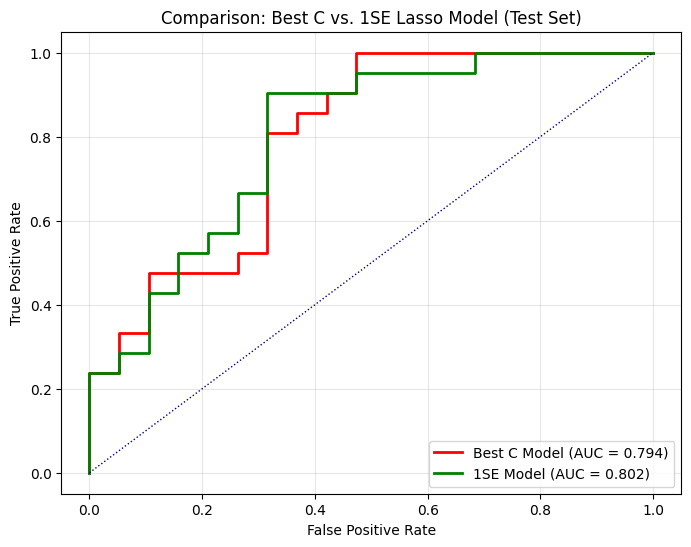

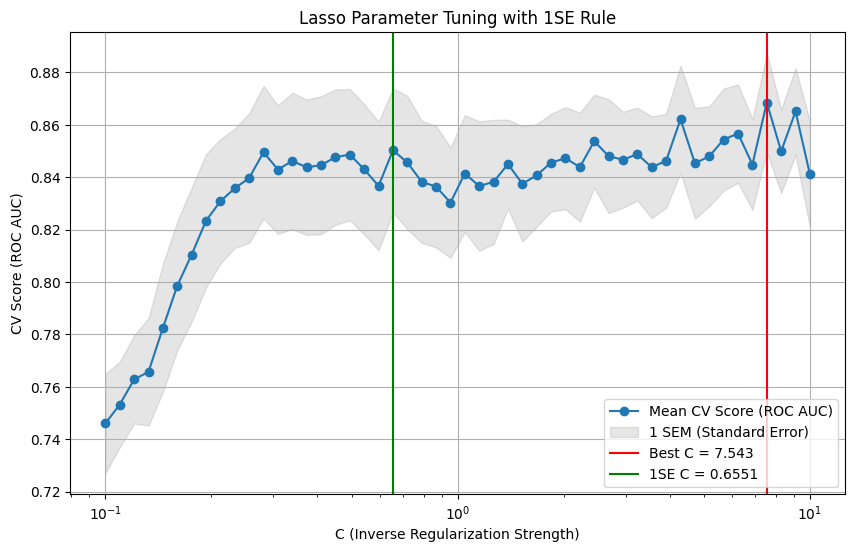

In [ ]:

# 3. Create Common Plot
plt.figure(figsize=(8, 6))

# Curve 1: Best C (e.g., in Blue)
plt.plot(fpr_best_test, tpr_best_test, color='red', lw=2, 
         label=f'Best C Model (AUC = {auc_best_test:.3f})')

# Kurve 2: 1SE Model (z.B. in Grün oder Orange)
plt.plot(fpr_1se_test, tpr_1se_test, color='green', lw=2,
         label=f'1SE Model (AUC = {auc_1se_test:.3f})')

# Diagonale (Zufallslinie)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle=':')

plt.title('Comparison: Best C vs. 1SE Lasso Model (Test Set)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/{SPECIFIC_GROUP_FILE}/{BIN_SIZE}/roc_curve_both.png")


plt.show()

# --- Lasso Parameter Tuning Plot ---
plt.figure(figsize=(10,6))
plt.semilogx(cs, mean_scores, marker='o', label='Mean CV Score (ROC AUC)')
plt.fill_between(cs, mean_scores - sem_scores, mean_scores + sem_scores, alpha=0.2, color='gray', label='1 SEM (Standard Error)')
plt.axvline(best_c, color='r', label=f'Best C = {best_c:.3f}')
plt.axvline(c_1se, color='g', label=f'1SE C = {c_1se:.4f}')
plt.title("Lasso Parameter Tuning with 1SE Rule")
plt.xlabel("C (Inverse Regularization Strength)")
plt.ylabel("CV Score (ROC AUC)")
plt.legend()
plt.grid(True)
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/{SPECIFIC_GROUP_FILE}/{BIN_SIZE}/lasso_parameter_tuning.png")
plt.show()


stability_df_output['test auc c'] = auc_best_test
stability_df_output['test auc 1se'] = auc_1se_test




## 5.2 Training vs. Test with best model 

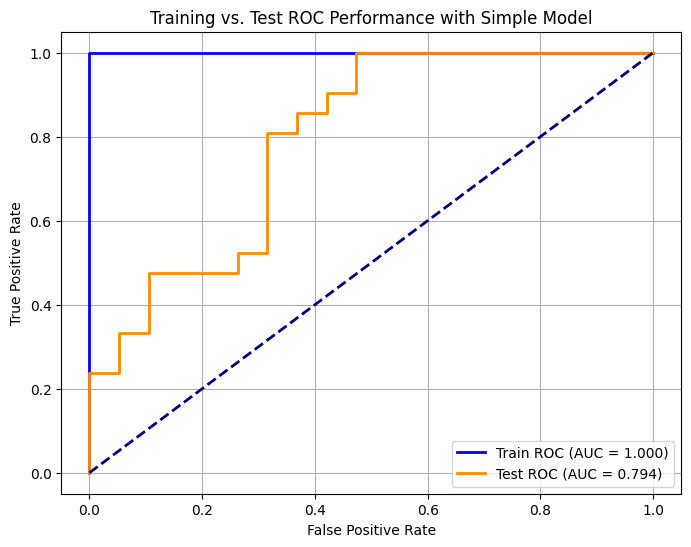

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_best_train, tpr_best_train, color='blue', lw=2, label=f'Train ROC (AUC = {auc_best_train:.3f})')
plt.plot(fpr_best_test, tpr_best_test, color='darkorange', lw=2, label=f'Test ROC (AUC = {auc_best_test:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.title('Training vs. Test ROC Performance with Simple Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/{SPECIFIC_GROUP_FILE}/{BIN_SIZE}/Training_Test_BEST_C.png")

plt.show()
stability_df_output['train auc c'] = auc_best_train

## 5.3 Training vs. Test with 1SE Model

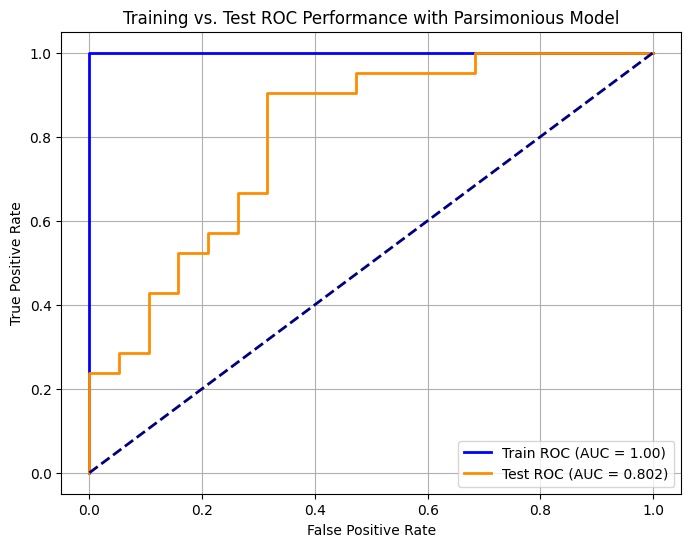

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_1se_train, tpr_1se_train, color='blue', lw=2, label=f'Train ROC (AUC = {auc_1se_train:.2f})')
plt.plot(fpr_1se_test, tpr_1se_test, color='darkorange', lw=2, label=f'Test ROC (AUC = {auc_1se_test:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.title('Training vs. Test ROC Performance with Parsimonious Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/{SPECIFIC_GROUP_FILE}/{BIN_SIZE}/Training_Test_1SE_C.png")
plt.show()

stability_df_output['train auc 1se'] = auc_1se_train

# 6. Selected Important Features


## 6.1 Pipeline with best model

                Feature  Coefficient
0  mean_chr10_100970000    -0.215137
1  mean_chr10_100985000     0.000000
2  mean_chr10_100995000     0.000000
3  mean_chr10_101060000     0.000000
4  mean_chr10_101405000     0.000000
SINGLE MODEL (Best C)
Number of Important Features (Best Model): 172

Top Features (Best Model - Positive = Indicative for Cancer):


<Axes: title={'center': 'Top Features (Best Model - Positive = Indicative for Cancer)'}, ylabel='Feature'>

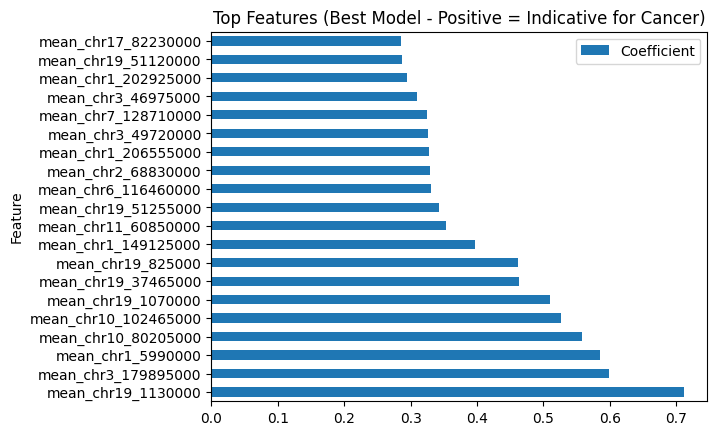

In [ ]:
from cv_lasso_single_fold import cross_validation, analyze_feature_stability, plot_roc_curves, plot_auc_boxplot

lasso_model = simple_pipeline.named_steps['lasso_cv']

coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": lasso_model.coef_[0]
})
print(coef_df.head())
important_features = coef_df[coef_df["Coefficient"] != 0].sort_values(by="Coefficient", ascending=False)

print("SINGLE MODEL (Best C)")
print(f"Number of Important Features (Best Model): {len(important_features)}")
print("\nTop Features (Best Model - Positive = Indicative for Cancer):")
important_features.head(20).plot.barh(x="Feature", y="Coefficient", title="Top Features (Best Model - Positive = Indicative for Cancer)")


## 6.2 Stable Pipeline with 1SE model 


STABLE MODEL (c_1se):
Number of Important Features (Stable Model): 86

Top Features (Stable Model - Positive = Indicative for Cancer):


COMPARISON:
Best C Model: 172 features selected
1SE Model:    86 features selected
Difference:   86 fewer features in 1SE model
stable_important_features:                    Feature  Coefficient
1984    mean_chr19_1130000     0.535545
17    mean_chr10_102465000     0.522984
3676   mean_chr3_179895000     0.515195
3511    mean_chr2_68830000     0.365922
183    mean_chr10_80205000     0.322645
...                    ...          ...
4495    mean_chr6_52085000    -0.411134
4485    mean_chr6_44245000    -0.523847
1644   mean_chr17_40820000    -0.528235
965   mean_chr14_104115000    -0.636022
2977   mean_chr20_52615000    -0.873678

[86 rows x 2 columns]


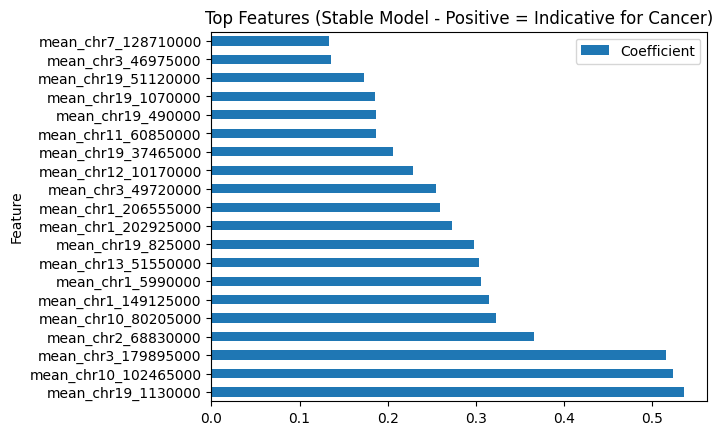

In [ ]:

stable_model = stable_pipeline.named_steps['stable_model']

stable_coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": stable_model.coef_[0]
})

stable_important_features = stable_coef_df[stable_coef_df["Coefficient"] != 0].sort_values(by="Coefficient", ascending=False)

print("STABLE MODEL (c_1se):")
print(f"Number of Important Features (Stable Model): {len(stable_important_features)}")
print(f"\nTop Features (Stable Model - Positive = Indicative for Cancer):")
stable_important_features.head(20).plot.barh(x="Feature", y="Coefficient", title="Top Features (Stable Model - Positive = Indicative for Cancer)")

print("\n")
print("COMPARISON:")
print(f"Best C Model: {len(important_features)} features selected")
print(f"1SE Model:    {len(stable_important_features)} features selected")
print(f"Difference:   {len(important_features) - len(stable_important_features)} fewer features in 1SE model")

print(f"stable_important_features: {stable_important_features}")


# 7. Feature Stability Analysis (Cross-Validation) 


In [ ]:
import importlib
import cv_lasso_single_fold
importlib.reload(cv_lasso_single_fold)
from cv_lasso_single_fold import plot_roc_curves, plot_auc_boxplot
print("Running 5-Fold Cross-Validation for Feature Stability.")


# hier macht es keinen sinn die stable pipeline zu nutzen, da in jedem fold mit dem gleichen c wert (c_1se) trainiert wird
cv_results = cross_validation(X_train, y_train, simple_pipeline, n_folds=5)

plot_roc_curves(cv_results, SPECIFIC_GROUP_FILE)
plot_auc_boxplot(cv_results, SPECIFIC_GROUP_FILE)


Running 5-Fold Cross-Validation for Feature Stability.
Fold 1/5...
  AUC = 0.812, Best C = 5.17947467923121
Fold 2/5...
  AUC = 0.754, Best C = 2.9470517025518097
Fold 3/5...
  AUC = 0.883, Best C = 7.543120063354615
Fold 4/5...
  AUC = 0.971, Best C = 10.0
Fold 5/5...


KeyboardInterrupt: 

## 7.2 Table with Statistical Values

In [ ]:
from cv_lasso_single_fold import print_performance_table
stat_table = print_performance_table(cv_results)
print(stat_table)

#speicher die stat tabelle
stat_table.to_csv(f"/labmed/workspace/lotta/finaletoolkit/outputs/tables/stat_table_{BIN_SIZE}_{SPECIFIC_GROUP_FILE}.csv", index=False)

'''
Accuracy: Anteil korrekt klassifizierter Samples
Sensitivity: Wie viele Krebs-Patienten wurden erkannt (wichtig!)
Specificity: Wie viele Gesunde wurden korrekt erkannt
Precision: Von allen als "Krebs" vorhergesagten, wie viele waren wirklich Krebs
'''


   Fold       AUC  Accuracy  Sensitivity  Specificity  Precision     Best_C  \
0     1  0.843750  0.718750     0.562500     0.875000   0.818182  10.000000   
1     2  0.730469  0.718750     0.562500     0.875000   0.818182  10.000000   
2     3  0.945312  0.906250     0.875000     0.937500   0.933333  10.000000   
3     4  0.900000  0.774194     0.800000     0.750000   0.750000   4.291934   
4     5  0.720833  0.741935     0.666667     0.812500   0.769231  10.000000   
5  Mean  0.828073  0.771976     0.693333     0.850000   0.817786   8.858387   
6   Std  0.100239  0.078427     0.140825     0.071261   0.071246   2.552725   

   N_Features  
0  156.000000  
1  158.000000  
2  153.000000  
3  115.000000  
4  188.000000  
5  154.000000  
6   25.971138  


'\nAccuracy: Anteil korrekt klassifizierter Samples\nSensitivity: Wie viele Krebs-Patienten wurden erkannt (wichtig!)\nSpecificity: Wie viele Gesunde wurden korrekt erkannt\nPrecision: Von allen als "Krebs" vorhergesagten, wie viele waren wirklich Krebs\n'

## 7.3 Feature Stability Analyse



Top Stable Features (Selected across multiple folds):
                 Feature  Frequency  Frequency_Percent  Mean_Coef
104  mean_chr3_179850000          5              100.0   0.581745
5    mean_chr10_80200000          5              100.0   0.478203
106   mean_chr3_49700000          5              100.0   0.416126
64   mean_chr19_51100000          5              100.0   0.345599
75   mean_chr1_202900000          5              100.0   0.320456


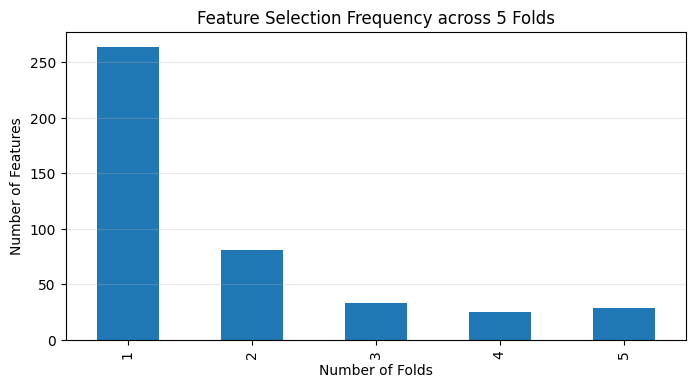

Features in ALL 5 folds: 29


In [ ]:
stability_df = analyze_feature_stability(cv_results)

stable_in_all = stability_df[stability_df['Frequency'] == 5]
print("\nTop Stable Features (Selected across multiple folds):")
print(stability_df.head(5))


plt.figure(figsize=(8, 4))
stability_df['Frequency'].value_counts().sort_index().plot(kind='bar')
plt.title('Feature Selection Frequency across 5 Folds')
plt.xlabel('Number of Folds')
plt.ylabel('Number of Features')
plt.grid(axis='y', alpha=0.3)
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/{SPECIFIC_GROUP_FILE}/{BIN_SIZE}/feature_selection_frequency.png")
plt.show()
print(f"Features in ALL 5 folds: {len(stable_in_all)}")

## 7.4 Feature Overlap Heatmap 


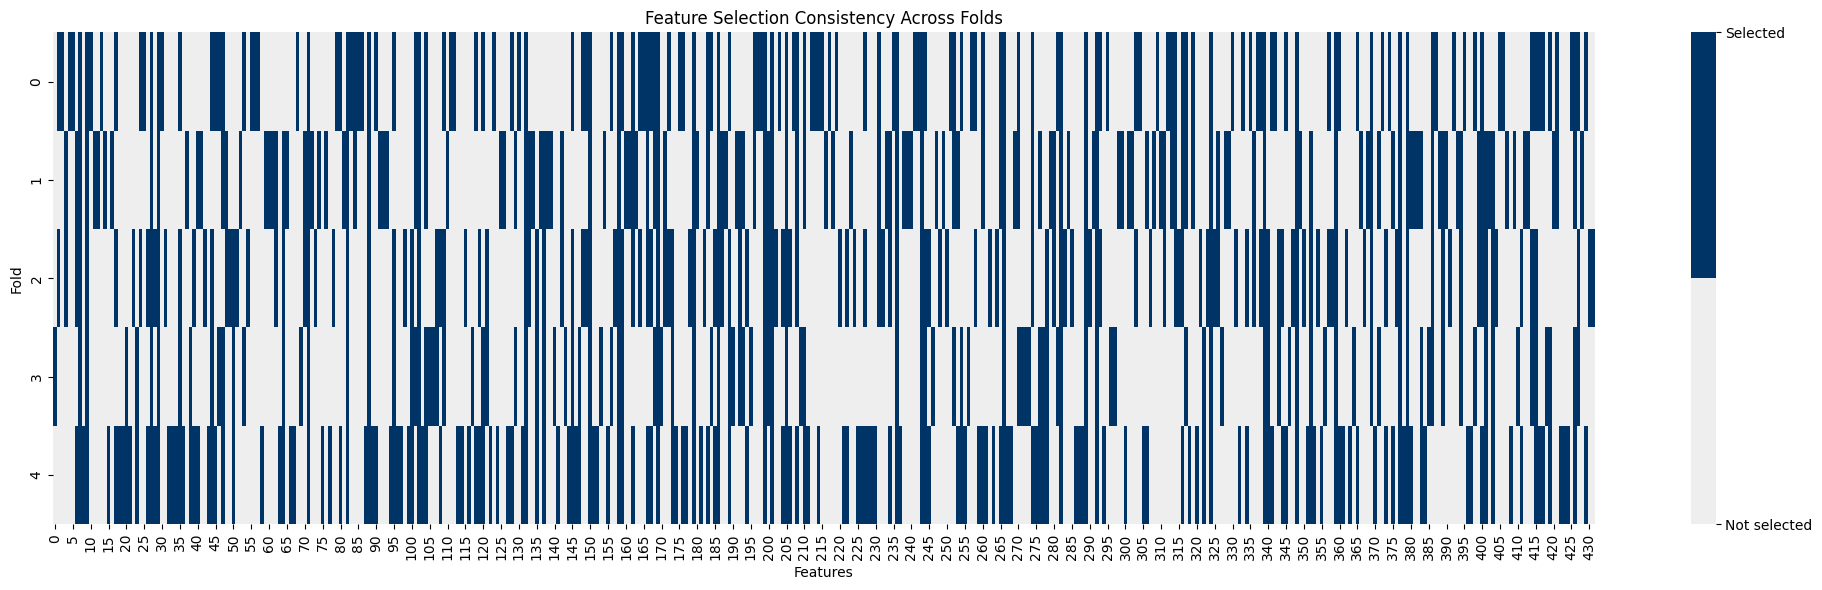

In [ ]:
all_features = sorted(list({
    feat
    for e in cv_results
    for feat in e['selected_features'].keys()
}))

matrix = np.zeros((5, len(all_features)))

for i, e in enumerate(cv_results):
    for j, feat in enumerate(all_features):
        if feat in e['selected_features']:
            matrix[i, j] = 1

# --- Binary colormap ---
cmap = ListedColormap(["#eeeeee", "#003366"])

plt.figure(figsize=(20, 6))
ax = sns.heatmap(
    matrix,
    cmap=cmap,
    vmin=0,
    vmax=1,
    cbar=True,
    cbar_kws={"ticks": [0, 1]}
)

# Custom colorbar labels
colorbar = ax.collections[0].colorbar
colorbar.set_ticklabels(["Not selected", "Selected"])

plt.xlabel("Features")
plt.ylabel("Fold")
plt.title("Feature Selection Consistency Across Folds")
plt.tight_layout()
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/{SPECIFIC_GROUP_FILE}/{BIN_SIZE}/feature_selection_heatmap.png")
plt.show()


## 7.5 Saving stable features in file for comparison

In [ ]:
import pandas as pd
from itertools import combinations

def extract_genomic_position(feature):
    if 'chr' in feature:
        return feature[feature.index('chr'):]
    return feature

metrics = {
    "mean": "stable_features_['mean']_50000_fold.csv",
    "stdev": "stable_features_['stdev']_50000_fold.csv",
    "wps": "stable_features_['wps_value']_50000_fold.csv",
    "mean_median_stdev": "stable_features_['mean', 'median', 'stdev']_50000_fold.csv"
}

base_path = "/labmed/workspace/lotta/finaletoolkit/outputs/statistics/"

feature_sets = {}

for metric, file in metrics.items():
    df = pd.read_csv(base_path + file)
    cleaned = {extract_genomic_position(f) for f in df['Feature']}
    feature_sets[metric] = cleaned


for (m1, f1), (m2, f2) in combinations(feature_sets.items(), 2):
    intersection = f1 & f2
    print(
        f"Intersection between {m1} and {m2}: "
        f"{len(intersection)} stable features\n{intersection}\n"
    )


Intersection between mean and stdev: 4 stable features
{'chr1_202900000', 'chr6_20400000', 'chr7_149100000', 'chr1_248500000'}

Intersection between mean and wps: 8 stable features
{'chr17_4800000', 'chr1_2150000', 'chr17_75200000', 'chr8_8950000', 'chr1_1600000', 'chr8_60950000', 'chr18_3850000', 'chr1_30700000'}

Intersection between mean and mean_median_stdev: 7 stable features
{'chr19_6700000', 'chr9_135700000', 'chr2_222600000', 'chr15_43650000', 'chr7_63350000', 'chr1_235300000', 'chr16_28350000'}

Intersection between stdev and wps: 0 stable features
set()

Intersection between stdev and mean_median_stdev: 0 stable features
set()

Intersection between wps and mean_median_stdev: 0 stable features
set()



# 8. Visualize the ROC Calculation (Label, Probability)

In [ ]:
# 1. Get the probabilities for the test set 
y_prob_test = simple_pipeline.predict_proba(X_test)[:, 1]

# 2. Create a DataFrame to map predictions to sample IDs
test_results = pd.DataFrame({
    'Sample_ID': X_test.index,
    'True_Label': y_test,
    'Probability_Cancer': y_prob_test
})

# 3. Sort the results by probability    
test_results = test_results.sort_values(by='Probability_Cancer', ascending=False).reset_index(drop=True)

# 4. Print the top 5 predictions
print("Detailed predicitions for test set:")
print(test_results.head(5))


Detailed predicitions for test set:
  Sample_ID  True_Label  Probability_Cancer
0   EE87884           1            0.999501
1   EE87809           1            0.999476
2   EE87881           1            0.999400
3   EE88304           1            0.999118
4   EE88292           1            0.997420


In [ ]:
# Falsch-Negative (Krebs als gesund vorhergesagt)
fn_proben = test_results[(test_results['True_Label'] == 1) & (test_results['Probability_Cancer'] < 0.3)]

# Falsch-Positive (Gesund als Krebs vorhergesagt)
fp_proben = test_results[(test_results['True_Label'] == 0) & (test_results['Probability_Cancer'] > 0.7)]

# Merge outliers with test_results to get the probabilities
outliers_meta = pd.concat([fn_proben, fp_proben])
if not outliers_meta.empty:
    ausreisser_klinik = clinical_df.merge(outliers_meta[['Sample_ID', 'Probability_Cancer', 'True_Label']], 
                                         left_on='Extracted_ID', right_on='Sample_ID')
    print(f"Found outliers with threshold (FN < 0.3, FP > 0.7): {len(ausreisser_klinik)}")
    print(ausreisser_klinik[['Extracted_ID', 'Patient Type', 'Gender', 'Probability_Cancer']])
else:
    print("No outliers found.")


Found outliers with threshold (FN < 0.3, FP > 0.7): 8
  Extracted_ID       Patient Type Gender  Probability_Cancer
0      EE87871  Colorectal Cancer      M            0.128867
1      EE87875  Colorectal Cancer      F            0.126543
2      EE87879  Colorectal Cancer      M            0.140036
3      EE87907     Gastric Cancer      M            0.207724
4      EE87917     Gastric Cancer      M            0.001063
5      EE87994            Healthy      M            0.958886
6      EE87968            Healthy      M            0.993676
7      EE87948            Healthy      F            0.725256


In [ ]:
stability_df_output.to_csv(f"/labmed/workspace/lotta/finaletoolkit/outputs/tables/stability_df_{BIN_SIZE}_{SPECIFIC_GROUP_FILE}.csv", index=False)

In [ ]:
print("Train label distribution:", np.unique(y_train, return_counts=True))


Train label distribution: (array([0, 1]), array([80, 78]))


In [ ]:
model = simple_pipeline.named_steps["lasso_cv"]

coefs = model.coef_[0]
features = X_train.columns

coef_df = pd.DataFrame({
    "feature": features,
    "coef": coefs
})

coef_df.sort_values("coef", ascending=False).head(20)


,feature,coef
1693,mean_chr19_37450000,0.465624
1917,mean_chr1_149100000,0.435850
3374,mean_chr5_175650000,0.404154
1730,mean_chr19_450000,0.386689
1784,mean_chr19_51100000,0.386636
370,mean_chr11_63450000,0.362799
157,mean_chr10_80200000,0.356553
6977,stdev_chr2_219200000,0.319288
1608,mean_chr19_1100000,0.318672
4009,mean_chr8_22950000,0.303708


In [ ]:
print("Mean fragment length per class:")
print("Healthy (0):", X_train[y_train==0].mean().mean())
print("Cancer  (1):", X_train[y_train==1].mean().mean())


Mean fragment length per class:
Healthy (0): 0.018284683087626295
Cancer  (1): -1.293248832166242


In [ ]:
# Differenz pro Feature: Cancer - Healthy
delta = X_train[y_train==1].mean() - X_train[y_train==0].mean()

# Welche mean_-Features sind bei Cancer höher?
delta_mean = delta[delta.index.str.startswith("mean_")].sort_values(ascending=False)

delta_mean.head(20), delta_mean.tail(20)


(mean_chr1_25250000     8.020486
 mean_chr1_120900000    7.641209
 mean_chr7_143800000    7.203421
 mean_chr15_43650000    3.524075
 mean_chr7_63750000     2.826555
 mean_chr16_18400000    2.443013
 mean_chr10_46450000    2.251918
 mean_chr11_90000000    2.154820
 mean_chr1_144150000    1.626714
 mean_chr7_63350000     1.578481
 mean_chr16_30150000    1.197881
 mean_chr4_131700000    1.184191
 mean_chr1_149100000    1.179198
 mean_chr10_80200000    1.098217
 mean_chr19_37450000    0.931120
 mean_chr21_43150000    0.790956
 mean_chr19_51100000    0.739913
 mean_chr1_202900000    0.722700
 mean_chr5_177850000    0.672917
 mean_chr19_1100000     0.632952
 dtype: float64,
 mean_chr7_75200000     -5.316148
 mean_chr1_149850000    -5.643843
 mean_chr11_55600000    -5.839762
 mean_chr1_2750000      -6.216574
 mean_chr1_144700000    -6.748709
 mean_chr15_43550000    -7.688931
 mean_chr1_248500000    -8.038893
 mean_chr10_47900000    -8.169644
 mean_chr16_28750000    -9.134245
 mean_chr16_28350

In [ ]:
coef = pd.Series(simple_pipeline.named_steps["lasso_cv"].coef_[0], index=X_train.columns)

# Nur Features, die das Modell nutzt
selected = coef[coef != 0].sort_values()

check = pd.DataFrame({
    "coef": selected,
    "delta_cancer_minus_healthy": delta[selected.index]
}).sort_values("coef", ascending=False)

check.head(30)


,coef,delta_cancer_minus_healthy
mean_chr19_37450000,0.465624,0.931120
mean_chr1_149100000,0.435850,1.179198
mean_chr5_175650000,0.404154,0.403531
mean_chr19_450000,0.386689,0.371817
mean_chr19_51100000,0.386636,0.739913
mean_chr11_63450000,0.362799,0.219254
mean_chr10_80200000,0.356553,1.098217
stdev_chr2_219200000,0.319288,0.032544
mean_chr19_1100000,0.318672,0.632952
mean_chr8_22950000,0.303708,0.100890
